# Imports

In [8]:
import datetime
import pandas as pd
import numpy as np
from transformers import TimeSeriesTransformerConfig
from gluonts.time_feature import get_lags_for_frequency, time_features_from_frequency_str

import matplotlib.pyplot as plt
%matplotlib inline

import sys, os
current_dir = os.getcwd()
scr = os.path.join(current_dir, 'scr')
sys.path.append(scr)
from c02_intensity_data_loader import *
from ts_trans_model import *

from datasets import load_from_disk

# Model Creation

In [7]:
# Define the model configurations
prediction_length = 24  # Predicting the next 24 hours
context_length = prediction_length * 2  # Adjust this value as needed
freq = "1h"
lags_sequence = get_lags_for_frequency(freq)
time_features = time_features_from_frequency_str(freq)

# List of zones for training
zones_list = ["FR", "DE", "ES"]

# Create zone to int and int to zone mappings
zone_to_int = {zone: idx for idx, zone in enumerate(zones_list)}
int_to_zone = {idx: zone for zone, idx in zone_to_int.items()}

# Create the model configuration
config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    context_length=context_length,
    lags_sequence=lags_sequence,
    num_time_features=len(time_features) + 1,  # +1 for the age feature
    num_static_categorical_features=1,
    cardinality=[len(zones_list)],  # Adjusted automatically
    embedding_dimension=[2],
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
    encoder_attention_heads=4,
    decoder_attention_heads=4,
    dim_feedforward=128,
    dropout=0.1,
    activation="gelu",
    num_parallel_samples=100,  # For generating predictions
    freq=freq,
    # Add mappings to the config
    zone_to_int=zone_to_int,
    int_to_zone=int_to_zone,
    zones_list=zones_list,
)

In [ ]:
model = TimeSeriesModel(config)

# Train

In [9]:
# train_start_date = "2024-04-01 00:00:00"
# train_end_date = "2024-08-20 00:00:00"
train_dataset = load_from_disk("data/train.pth/")

In [12]:
train_dataset[2]

{'start': datetime.datetime(2024, 4, 1, 0, 0, tzinfo=<UTC>),
 'target': [100.0,
  90.0,
  94.0,
  97.0,
  101.0,
  103.0,
  102.0,
  90.0,
  77.0,
  62.0,
  65.0,
  71.0,
  70.0,
  76.0,
  75.0,
  81.0,
  91.0,
  91.0,
  83.0,
  111.0,
  119.0,
  108.0,
  108.0,
  98.0,
  87.0,
  89.0,
  95.0,
  98.0,
  101.0,
  110.0,
  125.0,
  129.0,
  120.0,
  111.0,
  93.0,
  77.0,
  69.0,
  71.0,
  73.0,
  79.0,
  89.0,
  87.0,
  87.0,
  111.0,
  131.0,
  126.0,
  118.0,
  108.0,
  93.0,
  90.0,
  90.0,
  90.0,
  93.0,
  99.0,
  112.0,
  124.0,
  118.0,
  101.0,
  82.0,
  71.0,
  71.0,
  70.0,
  70.0,
  79.0,
  87.0,
  86.0,
  83.0,
  147.0,
  153.0,
  142.0,
  137.0,
  130.0,
  83.0,
  109.0,
  106.0,
  108.0,
  116.0,
  119.0,
  122.0,
  124.0,
  119.0,
  110.0,
  89.0,
  78.0,
  76.0,
  76.0,
  78.0,
  78.0,
  86.0,
  104.0,
  129.0,
  134.0,
  136.0,
  122.0,
  106.0,
  106.0,
  94.0,
  95.0,
  95.0,
  96.0,
  102.0,
  106.0,
  100.0,
  94.0,
  89.0,
  89.0,
  77.0,
  73.0,
  72.0,
  72.0,
  

In [21]:
dataset_creator = DataLoaderCreator(config)
train_dataloader = dataset_creator.create_train_dataloader(
    data=train_dataset,
    batch_size=64,
    num_batches_per_epoch=5,
)

In [22]:
model.train(train_dataloader, epochs = 10)

--- Epoch 1/10 ---
Epoch 1, Step 0, Loss: 4.3825
--- Epoch 2/10 ---
Epoch 2, Step 0, Loss: 4.4790
--- Epoch 3/10 ---
Epoch 3, Step 0, Loss: 4.4984
--- Epoch 4/10 ---
Epoch 4, Step 0, Loss: 4.3974
--- Epoch 5/10 ---
Epoch 5, Step 0, Loss: 4.4950
--- Epoch 6/10 ---
Epoch 6, Step 0, Loss: 4.3044
--- Epoch 7/10 ---
Epoch 7, Step 0, Loss: 4.3255
--- Epoch 8/10 ---
Epoch 8, Step 0, Loss: 4.5835
--- Epoch 9/10 ---
Epoch 9, Step 0, Loss: 4.4794
--- Epoch 10/10 ---
Epoch 10, Step 0, Loss: 3.9263


In [28]:
model.save('./models')

In [29]:
# For prediction, load the saved model and create the production DataLoader
model.load('./models')

# TEST

In [30]:
# Get production data (update the dates for production data)
# test_start_date = "2024-08-20 00:00:00"
# test_end_date = "2024-9-23 00:00:00"
test_dataset = load_from_disk('data/test.pth/')
test_dataloader = dataset_creator.create_backtest_dataloader(
    data=test_dataset,
    batch_size=64,
)

In [33]:
test_dataset

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 213
})

In [32]:
# Generate predictions on the test data
predictions_median, predictions_mean, predictions_std, sequences_array = model.predict_test(test_dataloader)

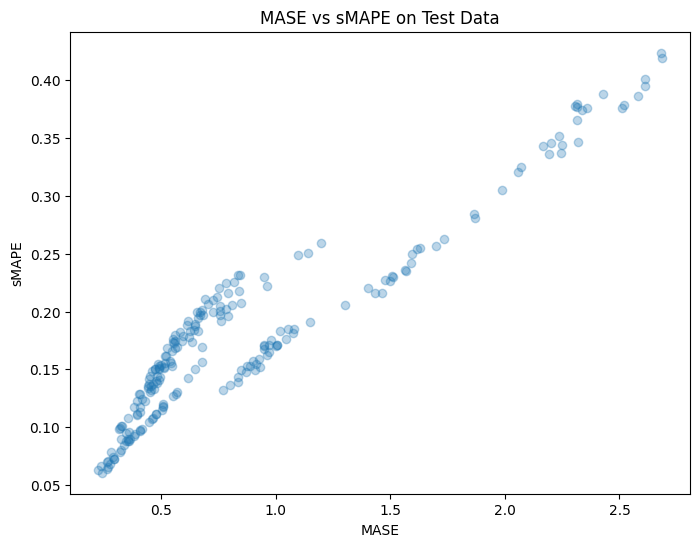

Mean MASE: 0.8821273540429929
Mean sMAPE: 0.18171406023067996


In [34]:
metrics = model.evaluate_test(predictions_mean, test_dataset)
print("Mean MASE:", np.mean(metrics["mase"]))
print("Mean sMAPE:", np.mean(metrics["smape"]))

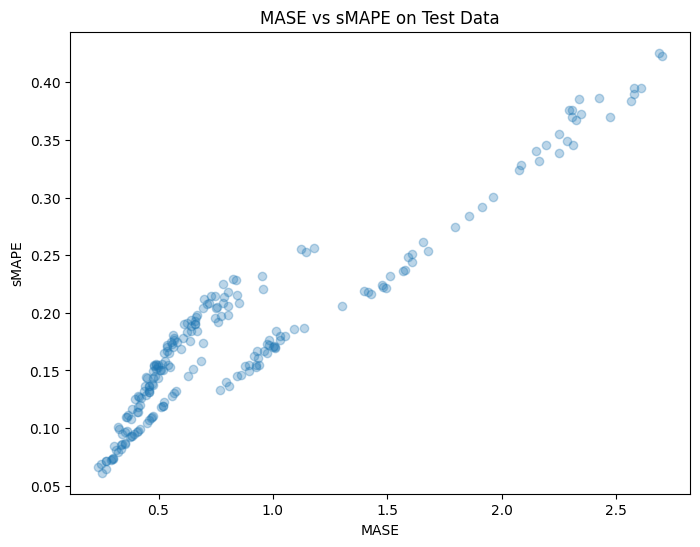

Mean MASE: 0.8837979835316102
Mean sMAPE: 0.18213141995519216


In [35]:
metrics = model.evaluate_test(predictions_median, test_dataset)
print("Mean MASE:", np.mean(metrics["mase"]))
print("Mean sMAPE:", np.mean(metrics["smape"]))

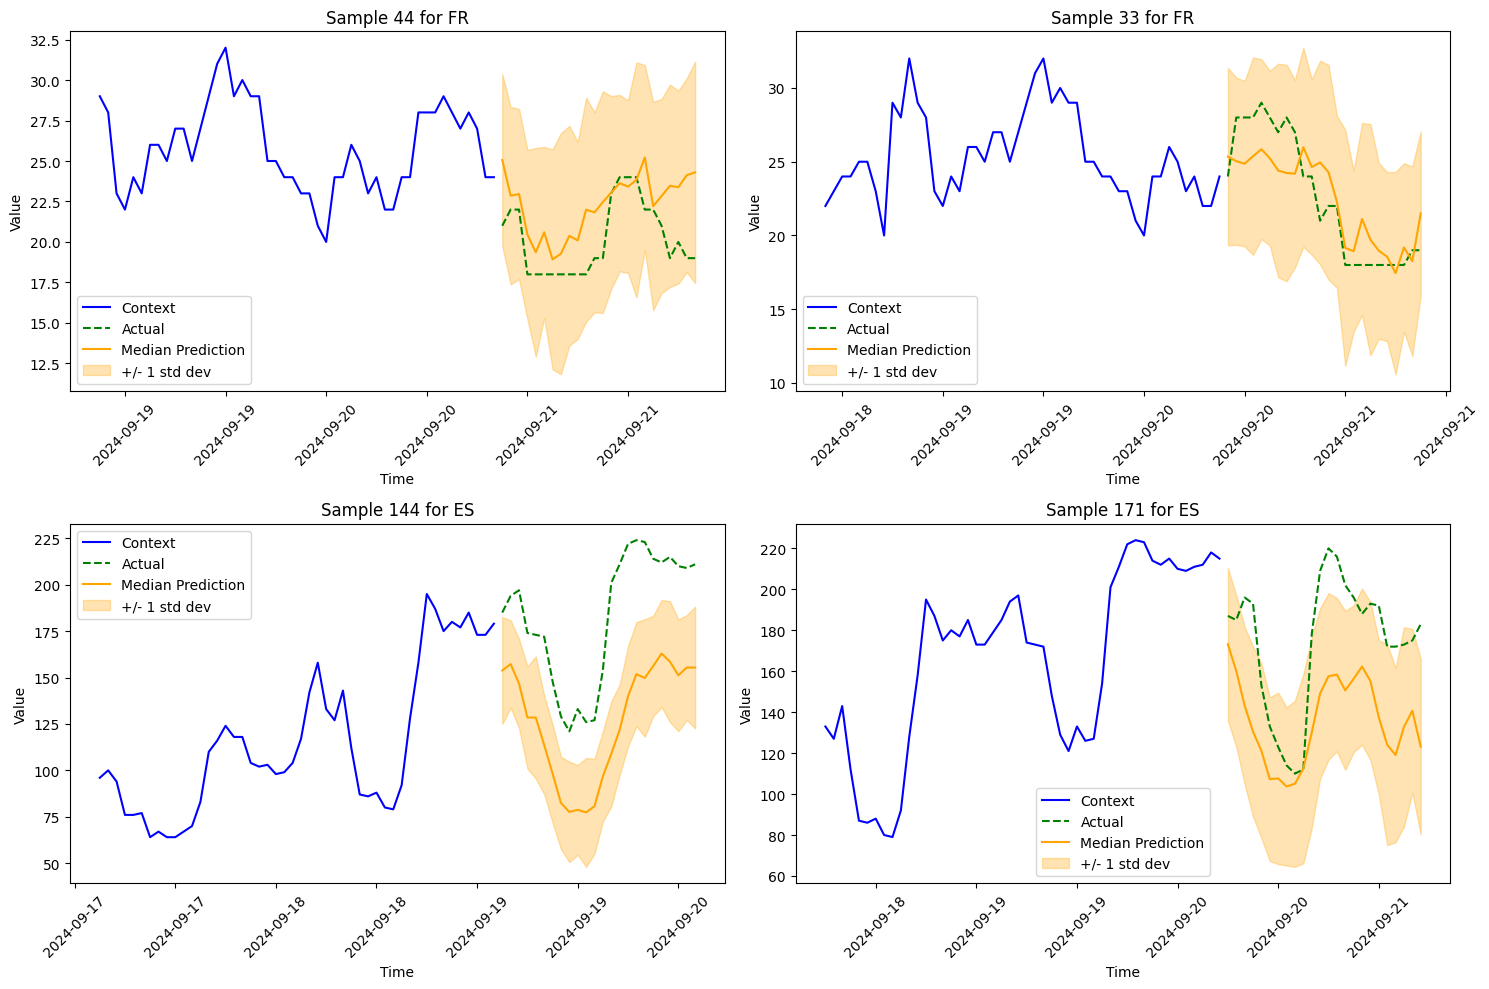

In [39]:
model.plot_test_predictions(test_dataset, sequences_array, num_plots=4)

PROD

In [43]:
# Get production data (update the dates for production data)
# production_start_date = "2024-10-11 00:00:00"
production_end_date = "2024-11-12 05:00:00"
production_dataset = load_from_disk('data/prod.pth/')
prod_dataloader = dataset_creator.create_prod_dataloader(
    data=production_dataset,
    batch_size=64,
)

In [44]:
production_end_date_datetime = datetime.datetime.strptime(production_end_date, "%Y-%m-%d %H:00:00")
predictions = model.predict(prod_dataloader, production_end_date_datetime)

In [46]:
predictions['FR']

{'dates': [Timestamp('2024-11-12 06:00:00'),
  Timestamp('2024-11-12 07:00:00'),
  Timestamp('2024-11-12 08:00:00'),
  Timestamp('2024-11-12 09:00:00'),
  Timestamp('2024-11-12 10:00:00'),
  Timestamp('2024-11-12 11:00:00'),
  Timestamp('2024-11-12 12:00:00'),
  Timestamp('2024-11-12 13:00:00'),
  Timestamp('2024-11-12 14:00:00'),
  Timestamp('2024-11-12 15:00:00'),
  Timestamp('2024-11-12 16:00:00'),
  Timestamp('2024-11-12 17:00:00'),
  Timestamp('2024-11-12 18:00:00'),
  Timestamp('2024-11-12 19:00:00'),
  Timestamp('2024-11-12 20:00:00'),
  Timestamp('2024-11-12 21:00:00'),
  Timestamp('2024-11-12 22:00:00'),
  Timestamp('2024-11-12 23:00:00'),
  Timestamp('2024-11-13 00:00:00'),
  Timestamp('2024-11-13 01:00:00'),
  Timestamp('2024-11-13 02:00:00'),
  Timestamp('2024-11-13 03:00:00'),
  Timestamp('2024-11-13 04:00:00'),
  Timestamp('2024-11-13 05:00:00')],
 'median_prediction': array([40.08184 , 40.916275, 38.921227, 44.458252, 43.731506, 43.95682 ,
        46.534756, 45.269203, 4